## Title Analysis and Cuisine

In [2]:
import pandas as pd 
import numpy as np
from foodrec.config.structure.paths import DATASET_PATHS
import joblib

### Load Data

In [20]:
df_cuisine = pd.read_csv(DATASET_PATHS / "cuisine_KOCHBAR.csv")
recipe_embedding = joblib.load(DATASET_PATHS / "recipe_embeddings_KOCHBAR.pkl")

In [21]:
df_cuisine.head()

,Unnamed: 0,recipe_name,rating_rate,views,average_rate,persone_number,ingredients,tutorial,difficulty,cooking_time,price_category,kcal,protein,carbohydrates,fat,for_diabetes,recipe_href,ingredients_normalized,cuisine
0,2,Mistkratzerli aus der Schweiz & Heidelbeerdess...,4,46,5,4.0,4 Stk.:Bio Hähnchenschlegel \n oder - \n 2 Stk...,"Hähnchen vierteilen, einreiben mit den Gewürze...",medium,80.0,2,199.0,3.9,9.3,16.1,1,/rezept/501146/Mistkratzerli-aus-der-Schweiz-H...,"['sugar', 'oil', 'black_pepper', 'chicken', 'b...",['latin_america']
1,4,Gesundes Abendessen !\nSüß und %x22 Bitter %x...,23,200,5,2.0,0.5 Stk.:Chicoree \n g:Feldsalat \n Dipp herst...,"Feldsalat putzen, waschen, schleudern. \n Bild...",easy,40.0,1,398.0,10.5,6.1,37.6,1,/rezept/500793/Gesundes-Abendessen.html,"['black_pepper', 'oil', 'chicory', 'mustard', ...",['latin_america']
2,6,Musik spezial / Zwiebelsalat\nBeilage für die ...,15,410,5,2.0,"1 Stück:Zwiebel, gewürfelt \n 6 Blatt:Basiliku...",%x22Musik spezial%x22: \n Die Zwiebel und das ...,easy,15.0,1,206.0,5.6,8.7,16.6,1,/rezept/498803/Musik-spezial-Zwiebelsalat.html,"['lemon_juice', 'beer', 'pepper', 'salt', 'sun...",['central_europe']
3,9,Karotten - Selleriesalat selber machen !\nWer ...,24,412,5,2.0,0.5 Stk.:Sellerie frisch \n Karotten aus dem G...,Wichtig ! ! \n Der Salat sollte schon 3-4 durc...,easy,20.0,1,302.0,1.3,14.8,26.5,1,/rezept/496245/Karotten-Selleriesalat-selber-m...,"['vinegar', 'salt', 'yogurt', 'rapeseed_oil', ...",['asia']
4,17,Gemüsebaum zwischen Garnelen !\nLow Carb.,22,250,5,2.0,aus meinem Garten - \n 4 Stk.:Karotten in Sche...,"Karotten ( klein) Grün abschneiden,waschen in ...",easy,60.0,1,2.0,0.4,0.5,0.0,1,/rezept/496114/Gemuesebaum-zwischen-Garnelen.html,"['salt', 'carrot', 'onion', 'water', 'prawn', ...",['central_europe']


In [22]:
recipe_embedding.keys()

dict_keys(['id', 'text_embeddings', 'descriptions'])

In [23]:
embedding_list = [vec for vec in recipe_embedding['text_embeddings']]

In [24]:
embedding_df = pd.DataFrame({
    'id':recipe_embedding['id'],
    'description':recipe_embedding['descriptions'],
    'embedding':embedding_list
})

In [25]:
df_cuisine_renamed = df_cuisine.rename(columns={'recipe_href': 'id'})

In [26]:
df_merged = embedding_df.merge(df_cuisine_renamed[['id', 'protein','kcal']], on='id', how='left')

In [27]:
def classify_protein(protein_val):
    if pd.isna(protein_val):
        return 'unbekannt'
    elif protein_val < 10:
        return 'leicht'
    elif protein_val < 25:
        return 'mittel'
    else:
        return 'hoch'


In [28]:
df_merged['protein_level'] = df_merged['protein'].apply(classify_protein)

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
X = np.vstack(embedding_df['embedding'].values)

labels = kmeans.fit_predict(X)
df_merged['cluster'] = labels

In [30]:
protein_distribution = df_merged.groupby('cluster')['protein_level'].value_counts(normalize=True).unstack()


In [31]:
print(protein_distribution)


protein_level      hoch    leicht    mittel
cluster                                    
0              0.001191  0.936762  0.062047
1              0.001300  0.849415  0.149285
2              0.003684  0.793291  0.203025
3              0.005659  0.691285  0.303056
4              0.003399  0.723424  0.273177


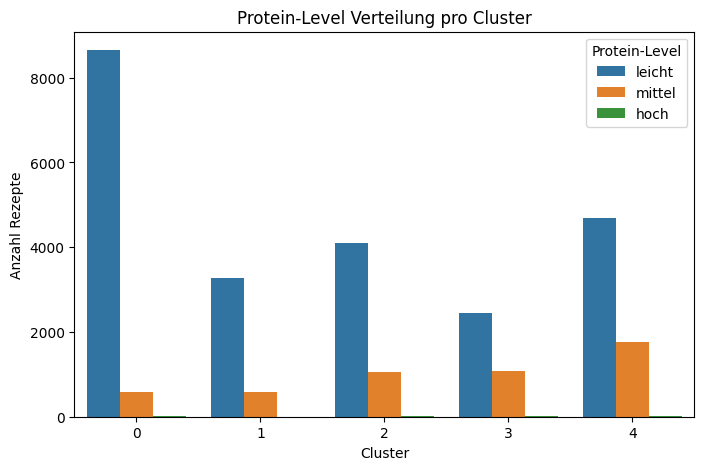

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df_merged, x='cluster', hue='protein_level')
plt.title("Protein-Level Verteilung pro Cluster")
plt.xlabel("Cluster")
plt.ylabel("Anzahl Rezepte")
plt.legend(title="Protein-Level")
plt.show()


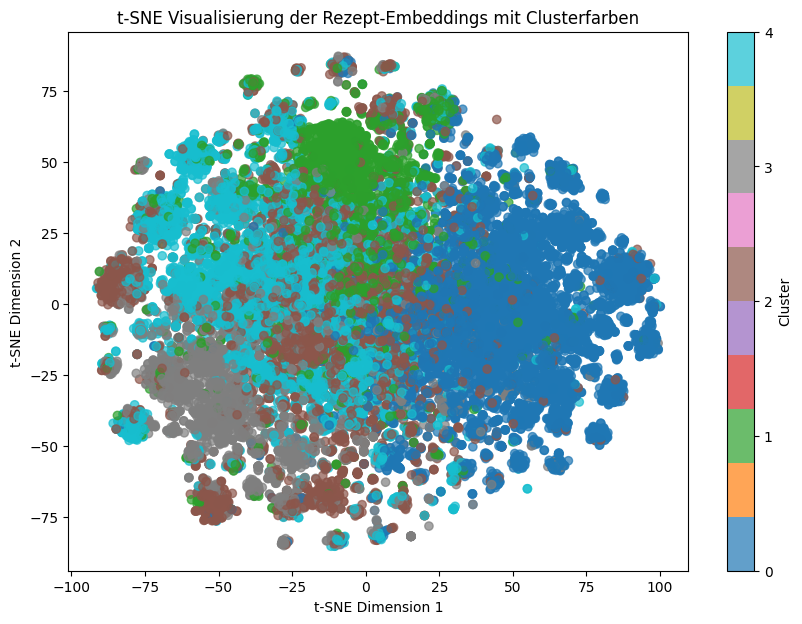

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 1. Embeddings als Matrix vorbereiten
X = np.vstack(df_merged['embedding'].values)

# 2. t-SNE auf 2D reduzieren
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# 3. Clusterlabels (falls noch nicht vorhanden, wie vorher)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# 4. Plot erstellen
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualisierung der Rezept-Embeddings mit Clusterfarben")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, ticks=range(5), label='Cluster')
plt.show()


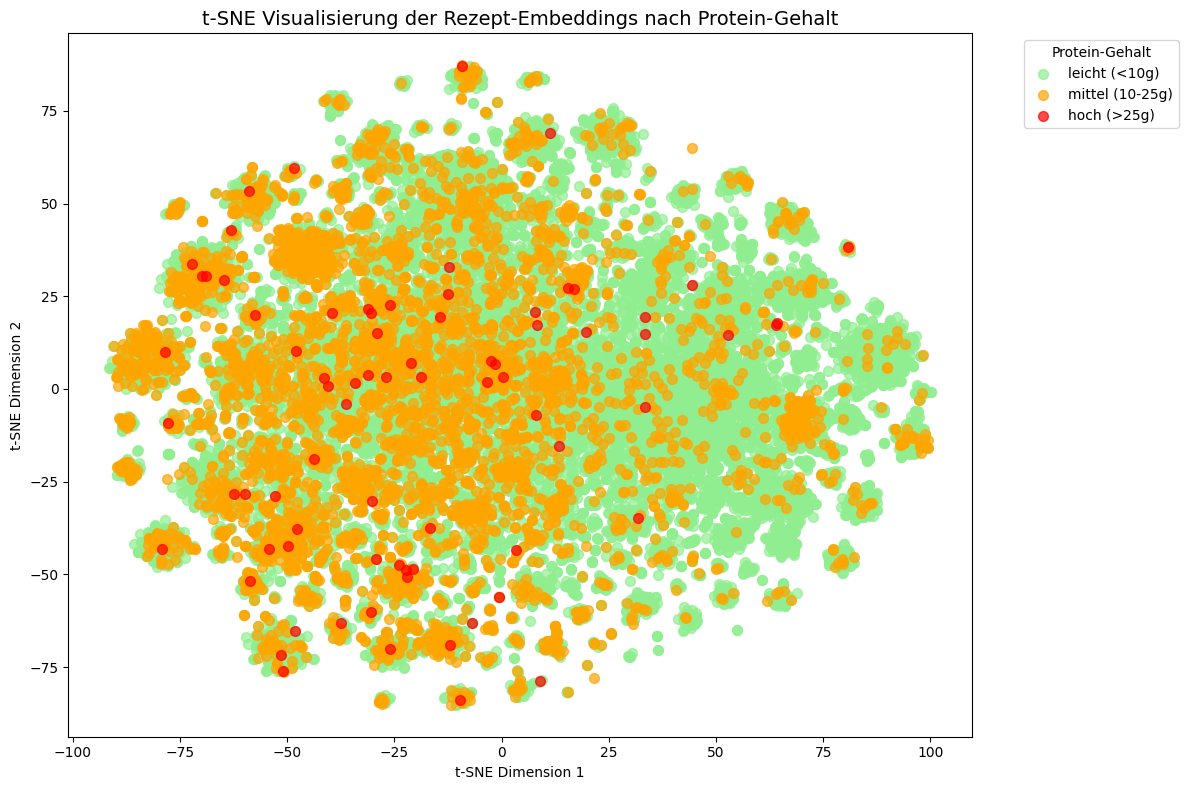

Verteilung der Protein-Level:
protein_level
leicht    23133
mittel     5033
hoch         77
Name: count, dtype: int64


In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# 1. Embeddings als Matrix vorbereiten
X = np.vstack(df_merged['embedding'].values)

# 2. t-SNE auf 2D reduzieren
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# 3. Protein-Level Klassifikation (falls noch nicht vorhanden)
def classify_protein(protein_val):
    if pd.isna(protein_val):
        return 'unbekannt'
    elif protein_val < 10:
        return 'leicht'
    elif protein_val < 25:
        return 'mittel'
    else:
        return 'hoch'

df_merged['protein_level'] = df_merged['protein'].apply(classify_protein)

# 4. Farbkodierung für Protein-Level
protein_levels = ['leicht', 'mittel', 'hoch', 'unbekannt']
colors = ['lightgreen', 'orange', 'red', 'gray']
color_map = dict(zip(protein_levels, colors))

# 5. Plot erstellen
plt.figure(figsize=(12, 8))

# Für jede Protein-Kategorie separat plotten für bessere Legende
for protein_level in protein_levels:
    mask = df_merged['protein_level'] == protein_level
    if mask.any():
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=color_map[protein_level], 
                   label=f'{protein_level} (<10g)' if protein_level == 'leicht' else
                         f'{protein_level} (10-25g)' if protein_level == 'mittel' else
                         f'{protein_level} (>25g)' if protein_level == 'hoch' else protein_level,
                   alpha=0.7, s=50)

plt.title("t-SNE Visualisierung der Rezept-Embeddings nach Protein-Gehalt", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Protein-Gehalt", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Zusätzliche Analyse - Anzahl pro Kategorie anzeigen
print("Verteilung der Protein-Level:")
print(df_merged['protein_level'].value_counts())

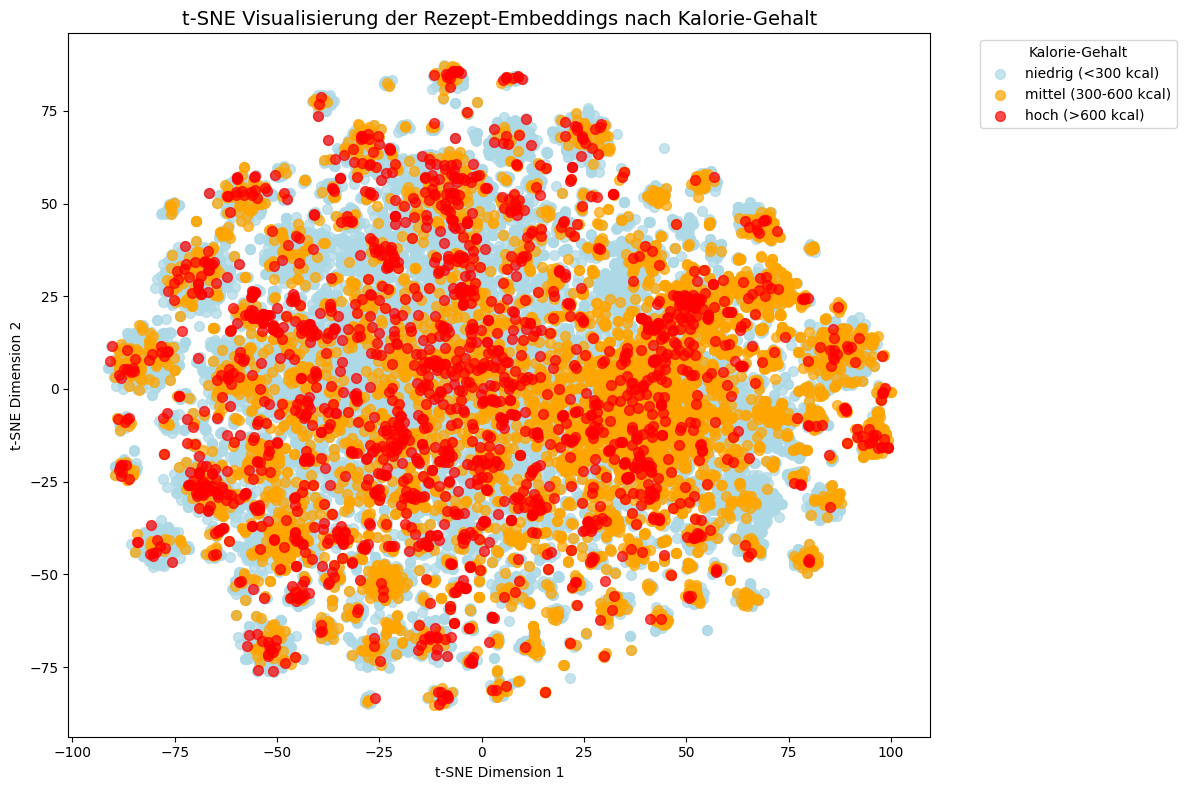

Verteilung der Kcal-Level:
kcal_level
niedrig    19177
mittel      7275
hoch        1791
Name: count, dtype: int64


In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# 1. Embeddings als Matrix vorbereiten
X = np.vstack(df_merged['embedding'].values)

# 2. t-SNE auf 2D reduzieren
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# 3. Kcal-Level Klassifikation
def classify_kcal(kcal_val):
    if pd.isna(kcal_val):
        return 'unbekannt'
    elif kcal_val < 300:
        return 'niedrig'
    elif kcal_val < 500:
        return 'mittel'
    else:
        return 'hoch'

df_merged['kcal_level'] = df_merged['kcal'].apply(classify_kcal)

# 4. Farbkodierung für Kcal-Level
kcal_levels = ['niedrig', 'mittel', 'hoch', 'unbekannt']
colors = ['lightblue', 'orange', 'red', 'gray']
color_map = dict(zip(kcal_levels, colors))

# 5. Plot erstellen
plt.figure(figsize=(12, 8))

# Für jede Kcal-Kategorie separat plotten für bessere Legende
for kcal_level in kcal_levels:
    mask = df_merged['kcal_level'] == kcal_level
    if mask.any():
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=color_map[kcal_level], 
                   label=f'{kcal_level} (<300 kcal)' if kcal_level == 'niedrig' else
                         f'{kcal_level} (300-600 kcal)' if kcal_level == 'mittel' else
                         f'{kcal_level} (>600 kcal)' if kcal_level == 'hoch' else kcal_level,
                   alpha=0.7, s=50)

plt.title("t-SNE Visualisierung der Rezept-Embeddings nach Kalorie-Gehalt", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Kalorie-Gehalt", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Zusätzliche Analyse - Anzahl pro Kategorie anzeigen
print("Verteilung der Kcal-Level:")
print(df_merged['kcal_level'].value_counts())

In [36]:
df_merged.head()

,id,description,embedding,protein,kcal,protein_level,cluster,kcal_level
0,/rezept/501146/Mistkratzerli-aus-der-Schweiz-H...,Recipe: Mistkratzerli aus der Schweiz & Heidel...,"[0.11684221, -0.2585938, -0.22058211, -0.13339...",3.9,199.0,leicht,2,niedrig
1,/rezept/500793/Gesundes-Abendessen.html,Recipe: Gesundes Abendessen !\nSüß und %x22 B...,"[0.08965781, -0.27352905, -0.32460642, 0.13668...",10.5,398.0,mittel,2,mittel
2,/rezept/498803/Musik-spezial-Zwiebelsalat.html,Recipe: Musik spezial / Zwiebelsalat\nBeilage ...,"[0.0064815134, -0.43023577, -0.34138057, 0.102...",5.6,206.0,leicht,4,niedrig
3,/rezept/496245/Karotten-Selleriesalat-selber-m...,Recipe: Karotten - Selleriesalat selber machen...,"[0.29627043, -0.4133869, -0.30860054, -0.03911...",1.3,302.0,leicht,1,mittel
4,/rezept/496114/Gemuesebaum-zwischen-Garnelen.html,Recipe: Gemüsebaum zwischen Garnelen !\nLow Ca...,"[0.1344827, -0.16210166, -0.23136657, 0.152385...",0.4,2.0,leicht,3,niedrig
